In [1]:
#essential imports
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

In [2]:
# Load the dataset
df = pd.read_csv('Database.csv')

Histogram saved as 'Wind_speed_histogram.png' in the same folder.


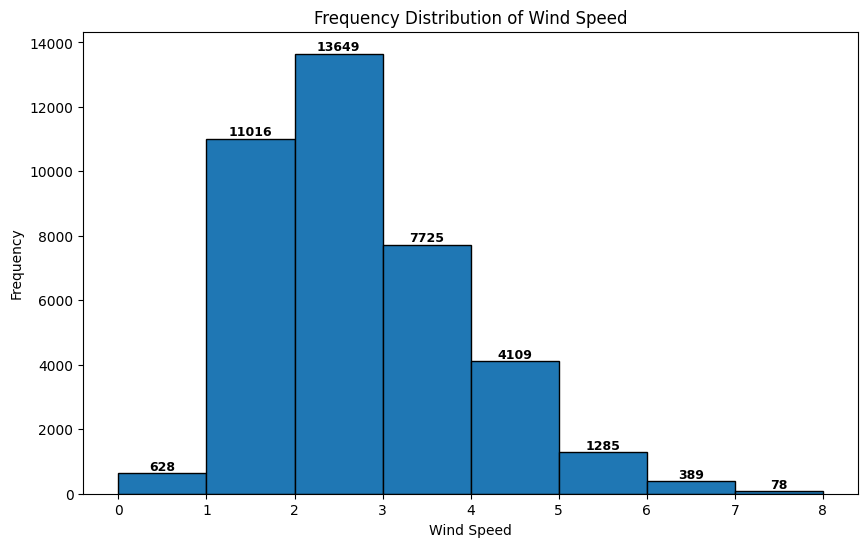

In [3]:
# Check if the 'Wind_speed' column exists
if 'Wind_speed' in df.columns:
    # Plotting the histogram
    plt.figure(figsize=(10, 6))
    n, bins, patches = plt.hist(
        df['Wind_speed'],
        bins=range(int(df['Wind_speed'].min()), int(df['Wind_speed'].max()) + 2, 1),
        edgecolor='black'
    )
    plt.title('Frequency Distribution of Wind Speed')
    plt.xlabel('Wind Speed')
    plt.ylabel('Frequency')

    # Add text labels on top of each bar
    for i in range(len(n)):
        plt.text(
            (bins[i] + bins[i+1]) / 2,  # x position (center of bin)
            n[i],                        # y position (on top of bar)
            str(int(n[i])),              # label (frequency)
            ha='center', va='bottom', fontsize=9, fontweight='bold'
        )

    # Save the plot
    plt.savefig('wind_speed_histogram.png')
    print("Histogram saved as 'Wind_speed_histogram.png' in the same folder.")
    plt.show()
else:
    print("Column 'Wind_speed' not found in the dataset.")

Histogram saved as 'humidity_histogram.png' in the same folder.


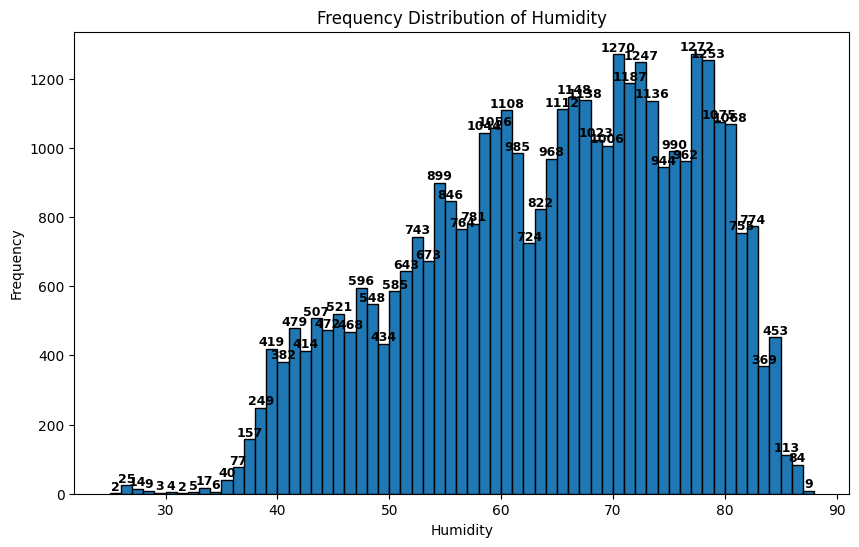

In [4]:
# Check if the 'Humidity' column exists
if 'Humidity' in df.columns:
    # Plotting the histogram
    plt.figure(figsize=(10, 6))
    n, bins, patches = plt.hist(
        df['Humidity'],
        bins=range(int(df['Humidity'].min()), int(df['Humidity'].max()) + 2, 1),
        edgecolor='black'
    )
    plt.title('Frequency Distribution of Humidity')
    plt.xlabel('Humidity')
    plt.ylabel('Frequency')

    # Add text labels on top of each bar
    for i in range(len(n)):
        plt.text(
            (bins[i] + bins[i+1]) / 2,  # x position (center of bin)
            n[i],                        # y position (on top of bar)
            str(int(n[i])),              # label (frequency)
            ha='center', va='bottom', fontsize=9, fontweight='bold'
        )

    # Save the plot
    plt.savefig('humidity_histogram.png')
    print("Histogram saved as 'humidity_histogram.png' in the same folder.")
    plt.show()
else:
    print("Column 'Humidity' not found in the dataset.")

Histogram saved as 'pv_production_histogram.png' in the same folder.


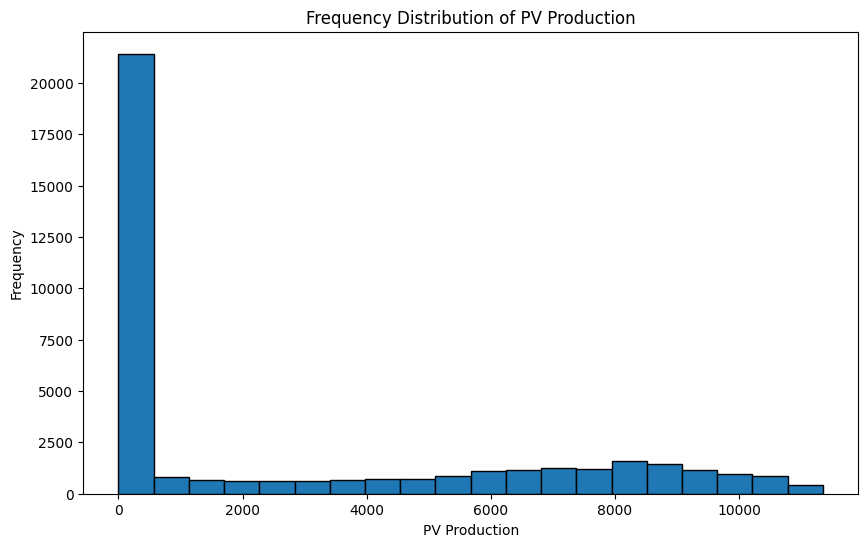

In [5]:
# Check if the 'PV_production' column exists
if 'PV_production' in df.columns:
    # Plotting the histogram for the 'PV_production' column
    plt.figure(figsize=(10, 6))
    plt.hist(df['PV_production'], bins=20, edgecolor='black')
    plt.title('Frequency Distribution of PV Production')
    plt.xlabel('PV Production')
    plt.ylabel('Frequency')
    
    # Save the plot in the same folder
    plt.savefig('pv_production_histogram.png')  # This saves it in the current working directory
    print("Histogram saved as 'pv_production_histogram.png' in the same folder.")
    # Show the plot
    plt.show()
else:
    print("Column 'PV_production' not found in the dataset.")

Histogram saved as 'temperature_histogram.png' in the same folder.


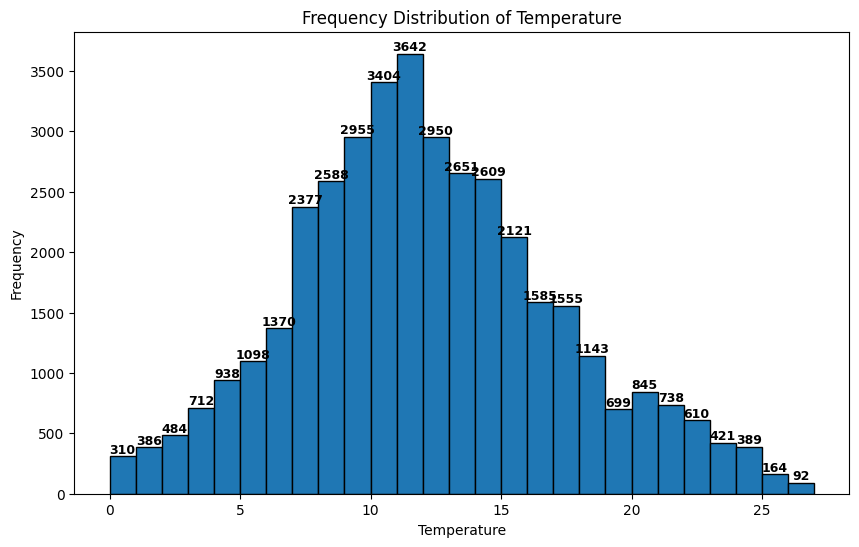

In [6]:
# Check if the 'Temperature' column exists
if 'Temperature' in df.columns:
    # Plotting the histogram
    plt.figure(figsize=(10, 6))
    n, bins, patches = plt.hist(
        df['Temperature'],
        bins=range(int(df['Temperature'].min()), int(df['Temperature'].max()) + 2, 1),
        edgecolor='black'
    )
    plt.title('Frequency Distribution of Temperature')
    plt.xlabel('Temperature')
    plt.ylabel('Frequency')

    # Add text labels on top of each bar
    for i in range(len(n)):
        plt.text(
            (bins[i] + bins[i+1]) / 2,  # x position (center of bin)
            n[i],                        # y position (on top of bar)
            str(int(n[i])),              # label (frequency)
            ha='center', va='bottom', fontsize=9, fontweight='bold'
        )

    # Save the plot
    plt.savefig('temperature_histogram.png')
    print("Histogram saved as 'temperature_histogram.png' in the same folder.")
    plt.show()
else:
    print("Column 'Temperature' not found in the dataset.")

Histogram saved as 'wind_production_histogram.png' in the same folder.


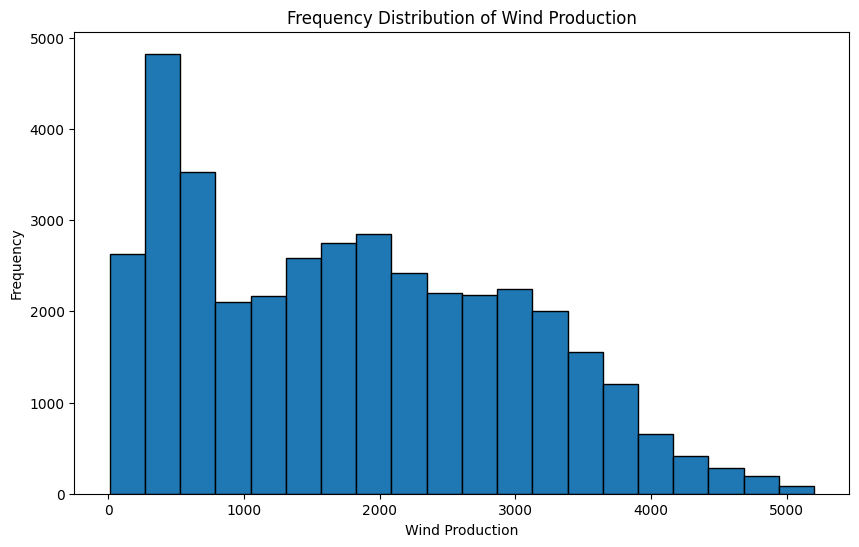

In [7]:
# Check if the 'Wind_production' column exists
if 'Wind_production' in df.columns:
    # Plotting the histogram for the 'Wind_production' column
    plt.figure(figsize=(10, 6))
    plt.hist(df['Wind_production'], bins=20, edgecolor='black')
    plt.title('Frequency Distribution of Wind Production')
    plt.xlabel('Wind Production')
    plt.ylabel('Frequency')
    
    # Save the plot
    plt.savefig('wind_production_histogram.png')
    print("Histogram saved as 'wind_production_histogram.png' in the same folder.")
    plt.show()
else:
    print("Column 'Wind_production' not found in the dataset.")

Histogram saved as 'electric_demand_histogram.png' in the same folder.


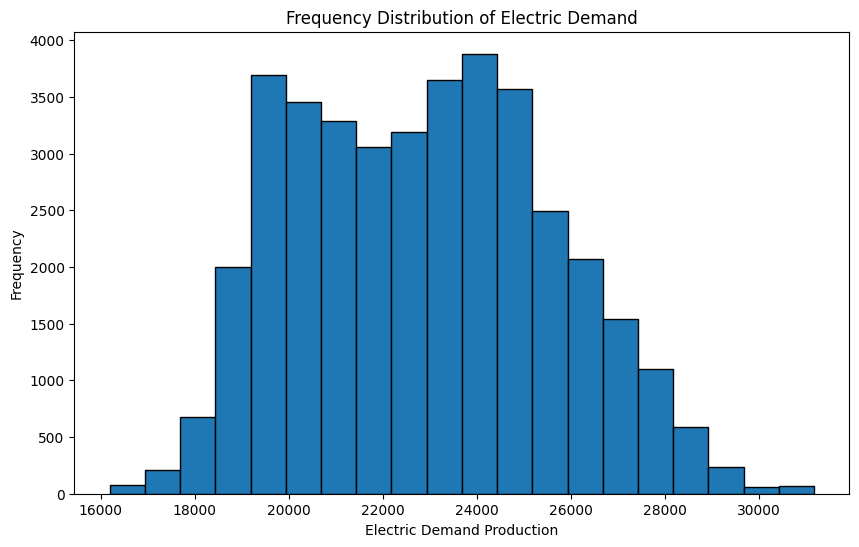

In [8]:
# Check if the 'Electric_demand' column exists
if 'Electric_demand' in df.columns:
    # Plotting the histogram for the 'Electric_demand' column
    plt.figure(figsize=(10, 6))
    plt.hist(df['Electric_demand'], bins=20, edgecolor='black')
    plt.title('Frequency Distribution of Electric Demand')
    plt.xlabel('Electric Demand Production')
    plt.ylabel('Frequency')
    
    # Save the plot
    plt.savefig('electric_demand_histogram.png')
    print("Histogram saved as 'electric_demand_histogram.png' in the same folder.")
    plt.show()
else:
    print("Column 'Electric_demand' not found in the dataset.")

In [9]:
# -------------------------------
# STEP 1: Outlier Detection & Removal using IQR
# -------------------------------

def remove_outliers_iqr(data, columns):
    clean_data = data.copy()
    for col in columns:
        if pd.api.types.is_numeric_dtype(clean_data[col]):
            Q1 = clean_data[col].quantile(0.25)
            Q3 = clean_data[col].quantile(0.75)
            IQR = Q3 - Q1
            lower = Q1 - 3.5 * IQR
            upper = Q3 + 3.5 * IQR
            # Remove rows outside range
            clean_data = clean_data[(clean_data[col] >= lower) & (clean_data[col] <= upper)]
    return clean_data

# List of numerical columns where we want to check outliers
num_cols = ['DHI','DNI','GHI','Wind_speed','Humidity',
            'Temperature','PV_production','Wind_production','Electric_demand']

df_clean = remove_outliers_iqr(df, num_cols)

print(f"Original shape: {df.shape}")
print(f"After outlier removal: {df_clean.shape}")

# -------------------------------
# STEP 2: Normalization (0 to 1 scaling)
# -------------------------------
scaler = MinMaxScaler()

df_scaled = df_clean.copy()
df_scaled[num_cols] = scaler.fit_transform(df_clean[num_cols])

# -------------------------------
# STEP 3: Save processed data
# -------------------------------
df_scaled.to_csv("preprocess_data.csv", index=False)
print("Preprocessed data saved as preprocess_data.csv")

Original shape: (38879, 13)
After outlier removal: (38879, 13)
Preprocessed data saved as preprocess_data.csv
